# What do I want?

- Match COSMOS galaxies to HSC objects 
    - (filter HSC for galaxies?)
- Remove non-matched HSC objects
- Apply a cut on COSMOS features
    - z < 0.15
    - M_stellar < 1e9
- Use that cut to create an HSC classification training set
- Run RF on that data set (pure HSC colors/fluxes!)
- Create confusion matrix
    - in particular, we're interested in the completeness after the inferred cut
    
    
This notebook is still a work-in-progress!

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors as colors

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

import astropy

import datasets
from matching import Matches

In [5]:
COSMOS = datasets.COSMOS("COSMOS_reference.sqlite")

In [6]:
HSC = datasets.HSC("HSC_COSMOS_median_forced.sqlite3")

In [7]:
COSMOS.df.shape

(518331, 14)

In [8]:
HSC.df.shape

(928534, 20)

In [9]:
downsample_factor_COSMOS = 1
mask_COSMOS_downsample = (COSMOS.df.index % downsample_factor_COSMOS == 0)

downsample_factor_HSC = 1
mask_HSC_downsample = (HSC.df.index % downsample_factor_HSC == 0)


matches = Matches(COSMOS,
                  HSC,
                  mask_catalog_1=mask_COSMOS_downsample,
                  mask_catalog_2=mask_HSC_downsample,
                 )

In [10]:
low_z = (matches.catalog_1.df[matches.mask_catalog_1].photo_z < .15)
low_mass = (matches.catalog_1.df[matches.mask_catalog_1].mass_med < 9)

# View distribution & cuts

These cuts define the population of galaxies we're trying to infer (low-z and low mass).

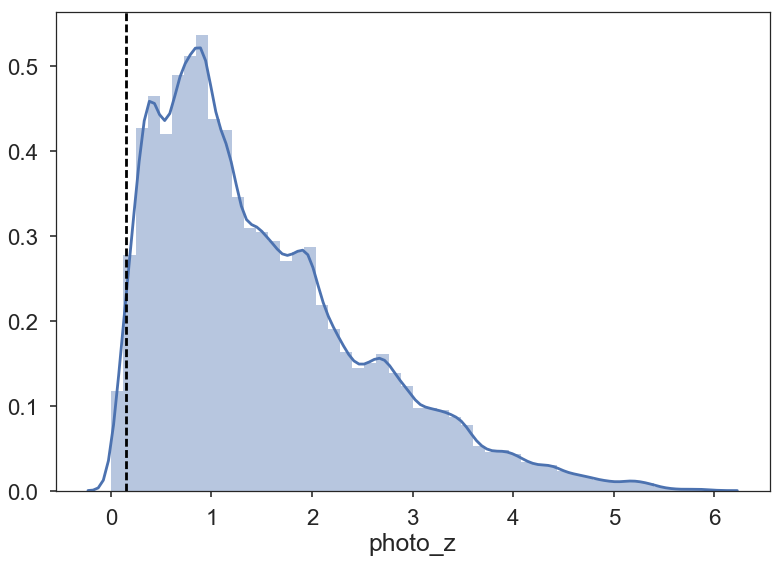

In [11]:
sns.distplot(matches.catalog_1.df[matches.mask_catalog_1].photo_z)
plt.axvline(.15, linestyle="dashed", color="k")

Let's see the redshift distribution for $z<0.15$

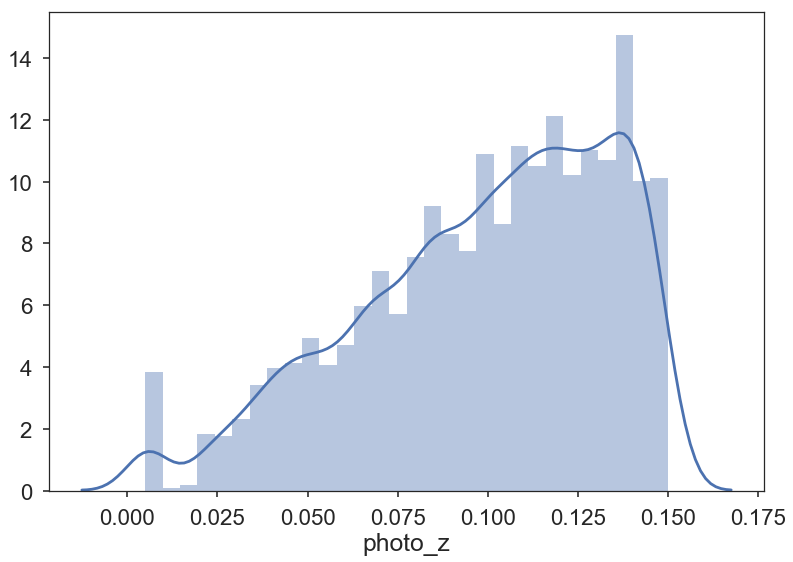

In [12]:
sns.distplot(matches.catalog_1.df[matches.mask_catalog_1].photo_z[low_z])

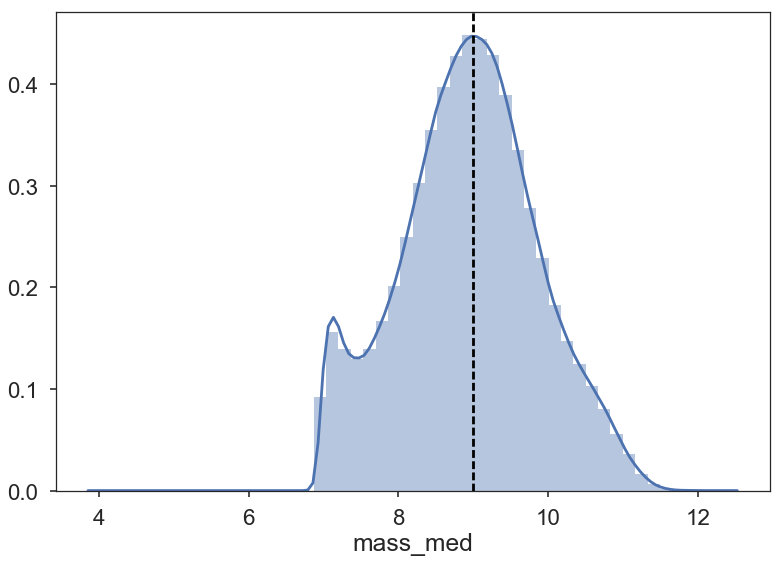

In [13]:
sns.distplot(matches.catalog_1.df[matches.mask_catalog_1].mass_med)

plt.axvline(9, linestyle="dashed", color="k")

# Create classification labels

Class A: matched **and** (low redshift + low mass)

Class B: matched **but not** (low redshift + low mass)

In [14]:
class_a = matches.mask_match & (low_z & low_mass)
class_b = matches.mask_match & ~(low_z & low_mass)

In [15]:
idxs = matches.idx[class_a.values]

In [16]:
class_a.mean()

0.016740268284165909

In [17]:
class_b.mean()

0.76481630463931349

In [18]:
class_a.sum() / (class_a.sum() + class_b.sum())

0.021419138248108514

In [19]:
class_b.sum() / (class_a.sum() + class_b.sum())

0.97858086175189152

In [20]:
matches.catalog_2.df["low_z_low_mass"] = False
# only change the flag if the object has been matched to, and if it is in class_a
matches.catalog_2.df.loc[matches.catalog_2.df.index[matches.mask_catalog_2][idxs],
                         ["low_z_low_mass"]] = True

In [21]:
# this is different from `class_a.mean()`
# because COSMOS galaxies (which `class_a` referred to)
# don't have a 1-to-1 map to HSC galaxies, even if they map
# (we expect ~2 HSC galaxies to map to a given COSMOS galaxy, on average)

# why this is lower, rather than higher, I don't know
matches.catalog_2.df["low_z_low_mass"].mean()

0.0093437612408377082

In [22]:
matches.catalog_2.df.low_z_low_mass.describe()

count     928534
unique         2
top        False
freq      919858
Name: low_z_low_mass, dtype: object

# Create a dataframe of just the matched galaxies

In [23]:
matched_hsc = matches.catalog_2.df[matches.mask_catalog_2].iloc[matches.idx[matches.mask_match]]

In [24]:
matched_hsc.describe()

,ra,dec,gcmodel_flux,gcmodel_flux_err,rcmodel_flux,rcmodel_flux_err,icmodel_flux,icmodel_flux_err,zcmodel_flux,zcmodel_flux_err,ycmodel_flux,ycmodel_flux_err
count,405105.000000,405105.000000,3.807070e+05,3.797180e+05,3.928980e+05,3.927810e+05,4.000690e+05,3.999100e+05,4.012240e+05,4.009350e+05,3.973020e+05,3.937970e+05
mean,150.125195,2.232177,5.425872e-30,2.441965e-31,1.029383e-29,2.389800e-31,1.654315e-29,4.080820e-31,2.199698e-29,5.481674e-31,2.490816e-29,1.632571e-30
std,0.348160,0.332707,3.119192e-29,7.493017e-32,7.011325e-29,7.309994e-30,1.066369e-28,1.406897e-31,1.414026e-28,2.049140e-31,1.637729e-28,5.286459e-31
min,149.504140,1.614650,-3.166004e-30,1.418267e-31,-1.065718e-26,1.085367e-31,-2.291145e-29,2.243794e-31,-1.310448e-29,3.025446e-31,-1.932652e-28,9.309609e-31
25%,149.834656,1.959245,9.857951e-31,1.992327e-31,1.456064e-30,1.718896e-31,1.963559e-30,3.232955e-31,2.287109e-30,4.324975e-31,2.040853e-30,1.329182e-30
50%,150.124488,2.227293,1.830453e-30,2.313752e-31,2.553482e-30,2.125267e-31,3.544400e-30,3.851301e-31,4.277338e-30,5.169591e-31,4.762685e-30,1.552165e-30
75%,150.408445,2.518028,3.803438e-30,2.696399e-31,5.449333e-30,2.561621e-31,8.000151e-30,4.524762e-31,1.040165e-29,6.113587e-31,1.168667e-29,1.814321e-30
max,150.786531,2.814174,5.125727e-27,8.857377e-30,1.073492e-26,4.581177e-27,1.528213e-26,1.509215e-29,1.988747e-26,2.604209e-29,2.235993e-26,8.761765e-29


In [25]:
matched_hsc.head()

,ra,dec,detect_is_patch_inner,detect_is_tract_inner,detect_is_primary,gcmodel_flux,gcmodel_flux_err,gcmodel_flux_flags,rcmodel_flux,rcmodel_flux_err,...,icmodel_flux,icmodel_flux_err,icmodel_flux_flags,zcmodel_flux,zcmodel_flux_err,zcmodel_flux_flags,ycmodel_flux,ycmodel_flux_err,ycmodel_flux_flags,low_z_low_mass
object_id,,,,,,,,,,,,,,,,,,,,,
43158996781122114,149.749414,1.618092,True,True,True,7.760156e-29,4.177573e-31,False,NaN,NaN,...,6.303301e-28,1.415450e-30,False,8.553727e-28,1.656983e-30,False,1.004911e-27,3.037335e-30,False,False
43158447025298860,150.388341,1.614668,True,True,True,5.800470e-31,2.102453e-31,False,1.333949e-30,1.788977e-31,...,2.348454e-30,5.105159e-31,False,1.967417e-30,4.042161e-31,False,4.328439e-31,1.392682e-30,False,False
43158447025298862,150.402906,1.614679,True,True,True,8.775548e-31,2.110055e-31,False,1.553413e-30,1.647729e-31,...,1.666095e-30,3.575105e-31,False,1.105359e-30,4.225365e-31,False,2.347631e-30,1.432457e-30,False,False
43158584464246387,150.295027,1.614650,True,True,True,1.312252e-30,3.044583e-31,False,2.617042e-30,2.799434e-31,...,3.989077e-30,5.396980e-31,False,4.817932e-30,7.052368e-31,False,3.960493e-30,2.091224e-30,False,False
43158584464253383,150.239846,1.614712,True,True,True,8.597155e-31,1.999684e-31,False,1.424355e-30,1.705562e-31,...,1.373718e-30,3.604136e-31,False,2.152825e-30,5.385489e-31,False,6.612980e-31,1.594763e-30,False,False


## Turn fluxes into rough colors
Yes, I know these aren't exactly the right colors since I'm not including zero-points, but that shouldn't affect the results.

(When I get a chance, I'll re-download the dataset so that it includes magnitudes not just fluxes)

In [26]:
matched_hsc["g_minus_r"] = -.4*np.log10(matched_hsc["gcmodel_flux"] / matched_hsc["rcmodel_flux"])
matched_hsc["r_minus_i"] = -.4*np.log10(matched_hsc["rcmodel_flux"] / matched_hsc["icmodel_flux"])
matched_hsc["i_minus_z"] = -.4*np.log10(matched_hsc["icmodel_flux"] / matched_hsc["zcmodel_flux"])
matched_hsc["z_minus_y"] = -.4*np.log10(matched_hsc["zcmodel_flux"] / matched_hsc["ycmodel_flux"])

/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/li

For now, filter out bad photometry. Later I could consider passing this into the classifier, as an imputed/sentinel value

In [27]:
mask =    np.isfinite(matched_hsc["g_minus_r"]) & np.isfinite(matched_hsc["r_minus_i"]) \
        & np.isfinite(matched_hsc["i_minus_z"]) & np.isfinite(matched_hsc["z_minus_y"]) \
        & np.isfinite(matched_hsc["icmodel_flux"]) \
        & (~matched_hsc.gcmodel_flux_flags) & (~matched_hsc.rcmodel_flux_flags) \
        & (~matched_hsc.icmodel_flux_flags) & (~matched_hsc.zcmodel_flux_flags) \
        & (~matched_hsc.ycmodel_flux_flags)

matched_hsc = matched_hsc[mask]

matched_hsc["log_icmodel_flux"] = np.log10(matched_hsc["icmodel_flux"])

In [28]:
matched_hsc.shape

(332712, 26)

In [29]:
features = matched_hsc.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                              "log_icmodel_flux"]]

target = matched_hsc.loc[:,["low_z_low_mass"]]

In [30]:
target.mean()

low_z_low_mass    0.022232
dtype: float64

# Build Classifier

## Partition training and testing sets

In [31]:
testing_fraction = .1
test_set_indices = np.random.choice(target.index.values, 
                                    replace=False,
                                    size=int(testing_fraction*target.size)
                                   )

training_set_indices = np.array(list(set(target.index.values) - set(test_set_indices)))

features_train = features.loc[training_set_indices]
features_test  = features.loc[test_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[test_set_indices]

## Random Forest: train & test

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
classifier = RandomForestClassifier()
classifier = classifier.fit(features_train, target_train.values.flatten())

In [34]:
target_predicted_simple = classifier.predict(features_test)

In [35]:
target_prob = classifier.predict_proba(features_test)[:,1]
target_predicted = (target_prob > .01)

In [36]:
target_prob.min()

0.0

In [37]:
target_prob.max()

1.0

In [38]:
target_prob.mean()

0.024083785322585476

In [39]:
# When you use a symmetric loss function
# (i.e. weight false positive and false negatives equally)
target_predicted_simple.mean()

0.0026969524437385753

In [40]:
# When you use an asymmetric loss function
# (i.e. value completeness more than purity)
target_predicted.mean()

0.16882922297803482

In [41]:
# Actual values
target_test.values.flatten().mean()

0.022804231218722843

## Random Forest:  Create Confusion Matrix

In [42]:
target_predicted

array([ True, False,  True, ..., False, False, False], dtype=bool)

In [43]:
true_a =  target_test.values.flatten()
true_b = ~target_test.values.flatten()

predicted_a =  target_predicted
predicted_b = ~target_predicted

In [44]:
true_a.size

33371

In [45]:
true_a.sum()

761

In [46]:
predicted_a.sum()

5634

In [47]:
(true_a & predicted_a).sum()

346

In [48]:
completeness = (true_a & predicted_a).sum() / (true_a).sum() 
completeness

0.45466491458607095

In [49]:
purity = (true_a & predicted_a).sum() / (predicted_a).sum() 
purity

0.061412850550230741

## Random Forest: Compare to overall fraction in training set

How does this RF method compare to subsampling randomly

In [50]:
true_a.size

33371

In [51]:
predicted_a.size

33371

In [52]:
print("Completeness with random sampling: ", predicted_a.sum() / predicted_a.size)
print("Completeness with smart  sampling: ", completeness)

Completeness with random sampling:  0.168829222978
Completeness with smart  sampling:  0.454664914586


In [53]:
print("Purity with random sampling: ", true_a.sum() / true_a.size)
print("Purity with smart sampling : ", purity)

Purity with random sampling:  0.0228042312187
Purity with smart sampling :  0.0614128505502


In [54]:
# by definition...
print("Sample size reduction with random sampling: ", (predicted_a.sum() / predicted_a.size)**-1)
print("Sample size reduction with smart sampling : ", (predicted_a.sum() / predicted_a.size)**-1)

Sample size reduction with random sampling:  5.92314518992
Sample size reduction with smart sampling :  5.92314518992


Okay, so our cut has improved purity by a factor of 2-3, relative to downsampling the catalog at random.

Unfortunately, our completeness isn't great: we're down to ~40%

# To do:
- Find a better algorithm?
 - We really aren't doing the type of classification that RandomForest is trying to optimize. It cares more about purity, but I'm more worried about completeness

## Logistic Regression: train & test

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
classifier = LogisticRegression(class_weight="balanced")
classifier = classifier.fit(features_train, np.array(target_train.values.flatten(), dtype=int))

In [57]:
target_predicted_simple = classifier.predict(features_test)

In [58]:
target_prob

array([ 0.1,  0. ,  0.2, ...,  0. ,  0. ,  0. ])

In [59]:
target_prob = classifier.predict_proba(features_test)[:,1]
target_predicted = (target_prob > .5)

In [60]:
target_prob.min()

4.8801011568399229e-05

In [61]:
target_prob.max()

0.99098464479162196

In [62]:
# When you use a symmetric loss function
# (i.e. weight false positive and false negatives equally)
target_predicted_simple.mean()

0.39270624194660037

In [63]:
# When you use an asymmetric loss function
# (i.e. value completeness more than purity)
target_predicted.mean()

0.39270624194660037

In [64]:
# Actual values
target_test.values.flatten().mean()

0.022804231218722843

## Logistic Regression: Create Confusion Matrix

In [65]:
target_predicted

array([False, False,  True, ...,  True, False, False], dtype=bool)

In [66]:
true_a =  target_test.values.flatten()
true_b = ~target_test.values.flatten()

predicted_a =  target_predicted
predicted_b = ~target_predicted

In [67]:
true_a.size

33371

In [68]:
true_a.sum()

761

In [69]:
predicted_a.sum()

13105

In [70]:
(true_a & predicted_a).sum()

494

In [71]:
completeness = (true_a & predicted_a).sum() / (true_a).sum() 
completeness

0.64914586070959268

In [72]:
purity = (true_a & predicted_a).sum() / (predicted_a).sum() 
purity

0.037695536054940859

## Logistic Regression: Compare to overall fraction in training set

How does this RF method compare to subsampling randomly

In [73]:
true_a.size

33371

In [74]:
predicted_a.size

33371

In [75]:
print("Completeness with random sampling: ", predicted_a.sum() / predicted_a.size)
print("Completeness with smart  sampling: ", completeness)

Completeness with random sampling:  0.392706241947
Completeness with smart  sampling:  0.64914586071


In [76]:
print("Purity with random sampling: ", true_a.sum() / true_a.size)
print("Purity with smart sampling : ", purity)

Purity with random sampling:  0.0228042312187
Purity with smart sampling :  0.0376955360549


In [77]:
# by definition...
print("Sample size reduction with random sampling: ", (predicted_a.sum() / predicted_a.size)**-1)
print("Sample size reduction with smart sampling : ", (predicted_a.sum() / predicted_a.size)**-1)

Sample size reduction with random sampling:  2.54643265929
Sample size reduction with smart sampling :  2.54643265929
